In [1]:
!pip install -r requirements.txt

In [2]:
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns
from scipy.stats import chi2_contingency
import pingouin
import folium  #needed for interactive map
from folium.plugins import HeatMap
%matplotlib inline
sns.set()

In [3]:
%%time
df = pd.read_csv('data/cleaned_ppp_data.csv.gz', compression="gzip", low_memory=False)

CPU times: user 1min 13s, sys: 1min 31s, total: 2min 45s
Wall time: 8min 20s


In [4]:
pd.options.display.max_columns = 100
df.head()

,DateApproved,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,LoanStatus,Term,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount,FranchiseName,ServicingLenderName,ServicingLenderCity,ServicingLenderState,ServicingLenderZip,RuralUrbanIndicator,HubzoneIndicator,LMIIndicator,BusinessAgeDescription,ProjectCity,ProjectCountyName,ProjectState,ProjectZip,CD,JobsReported,Race,Ethnicity,UtilitiesProceed,PayrollProceed,MortgageIntProceed,RentProceed,RefinanceEidlProceed,HealthcareProceed,DebtIntProceed,BusinessType,OriginatingLender,OriginatingLenderCity,OriginatingLenderState,Gender,Veteran,NonProfit,Industry
0,2020-05-01,NaN,NaN,NaN,NaN,EXEMPTION 4,24,148440.00,148440.00,0.0,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CHARLOTTE,NC,28202-4024,URBAN,NO,NO,NEW BUSINESS OR 2 YEARS OR LESS,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,148440.00,NaN,NaN,NaN,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CHARLOTTE,NC,NaN,NaN,NaN,DENTAL EQUIPMENT AND SUPPLIES MANUFACTURING
1,2020-05-01,LADSON,NaN,29456-3517,NaN,EXEMPTION 4,24,140081.78,140081.78,0.0,NaN,SYNOVUS BANK,COLUMBUS,GA,31901-2429,URBAN,NO,NO,EXISTING OR MORE THAN 2 YEARS OLD,LADSON,BERKELEY,SC,29456-3517,SC-01,3.0,NaN,NaN,NaN,140081.78,NaN,NaN,NaN,NaN,NaN,LIMITED LIABILITY COMPANY(LLC),SYNOVUS BANK,COLUMBUS,GA,NaN,NaN,NaN,NaN
2,2020-05-01,MANNING,NaN,29102-2734,2021-04-20,PAID IN FULL,24,136520.96,136520.96,0.0,NaN,SYNOVUS BANK,COLUMBUS,GA,31901-2429,URBAN,YES,YES,EXISTING OR MORE THAN 2 YEARS OLD,MANNING,CLARENDON,SC,29102-2734,SC-06,170.0,NaN,NaN,NaN,136520.96,NaN,NaN,NaN,NaN,NaN,LIMITED LIABILITY COMPANY(LLC),SYNOVUS BANK,COLUMBUS,GA,NaN,NaN,NaN,"ALL OTHER PROFESSIONAL, SCIENTIFIC, AND TECHNI..."
3,2020-05-01,REDFORD,NaN,48239-2446,2021-04-16,PAID IN FULL,24,126798.00,126798.00,0.0,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CHARLOTTE,NC,28202-4024,URBAN,YES,NO,NEW BUSINESS OR 2 YEARS OR LESS,REDFORD,WAYNE,MI,48239-2446,MI-13,20.0,NaN,NOT HISPANIC OR LATINO,NaN,126798.00,NaN,NaN,NaN,NaN,NaN,LIMITED LIABILITY COMPANY(LLC),"BANK OF AMERICA, NATIONAL ASSOCIATION",CHARLOTTE,NC,MALE OWNED,NON-VETERAN,NaN,NaN
4,2020-05-01,SPARTANBURG,NaN,29303-2085,NaN,EXEMPTION 4,24,125916.00,125916.00,0.0,NaN,SYNOVUS BANK,COLUMBUS,GA,31901-2429,URBAN,NO,YES,NEW BUSINESS OR 2 YEARS OR LESS,SPARTANBURG,SPARTANBURG,SC,29303-2085,SC-04,13.0,NaN,NaN,NaN,125916.00,NaN,NaN,NaN,NaN,NaN,LIMITED LIABILITY COMPANY(LLC),SYNOVUS BANK,COLUMBUS,GA,NaN,NaN,NaN,UNCLASSIFIED ESTABLISHMENTS


## Some basic data exploration

In [5]:
loan_amounts = df[['InitialApprovalAmount', 'CurrentApprovalAmount', 'UndisbursedAmount']]

In [6]:
loan_amounts.head()

,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount
0,148440.00,148440.00,0.0
1,140081.78,140081.78,0.0
2,136520.96,136520.96,0.0
3,126798.00,126798.00,0.0
4,125916.00,125916.00,0.0


In [7]:
loan_amounts.shape

(10697219, 3)

In [8]:
loan_amounts.describe()

,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount
count,1.069722e+07,1.069722e+07,1.068949e+07
mean,7.315910e+04,7.278606e+04,3.493252e+03
std,2.685807e+05,2.658448e+05,4.239380e+04
min,-1.996590e+05,0.000000e+00,-3.700000e+04
25%,9.747000e+03,9.727500e+03,0.000000e+00
50%,2.080000e+04,2.080000e+04,0.000000e+00
75%,4.481600e+04,4.468000e+04,0.000000e+00
max,1.000000e+07,1.000000e+07,1.000000e+07


In [9]:
#Noticed that there are outliers in the three columns
loan_amounts.skew()

InitialApprovalAmount     15.214813
CurrentApprovalAmount     15.157894
UndisbursedAmount        112.054169
dtype: float64

In [10]:
#Getting the 10 and 90 percentile to remove outliers
loan_amounts.quantile([0.75,0.90, 0.95, 0.99, 0.995])

,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount
0.750,44816.00,44680.000,0.0000
0.900,136700.00,136217.138,9416.0000
0.950,268200.00,267200.000,20832.0000
0.990,1011835.29,1006300.000,29116.1909
0.995,1609645.50,1599200.000,69430.0000


In [11]:
#Using the z-score to drop outliers
loan_amounts = loan_amounts[loan_amounts.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

In [12]:
loan_amounts.head()

,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount
0,148440.00,148440.00,0.0
1,140081.78,140081.78,0.0
2,136520.96,136520.96,0.0
3,126798.00,126798.00,0.0
4,125916.00,125916.00,0.0


In [13]:
loan_amounts.shape

(10529600, 3)

<AxesSubplot:title={'center':'Loan Amount'}, ylabel='Frequency'>

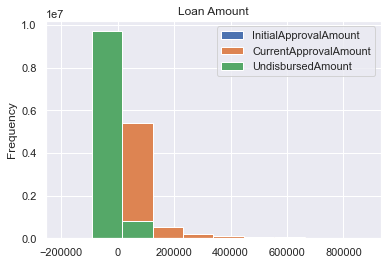

In [14]:
loan_amounts.plot.hist(title="Loan Amount")

<AxesSubplot:title={'center':'Loan Amount'}>

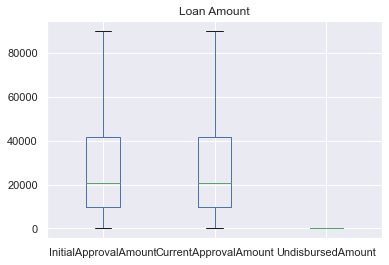

In [15]:
loan_amounts.plot.box(title="Loan Amount", showfliers=False)

<AxesSubplot:title={'center':'Initial Loan Amount'}, ylabel='Frequency'>

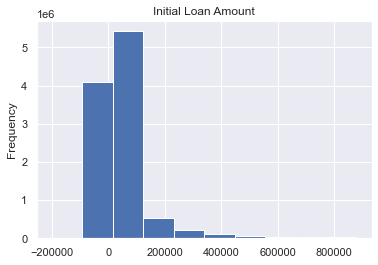

In [16]:
loan_amounts['InitialApprovalAmount'].plot.hist(title="Initial Loan Amount")

<AxesSubplot:title={'center':'Initial Loan Amount'}>

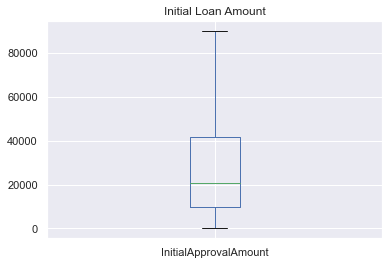

In [17]:
loan_amounts['InitialApprovalAmount'].plot.box(title="Initial Loan Amount", showfliers=False)

<AxesSubplot:title={'center':'Current Loan Amount'}, ylabel='Frequency'>

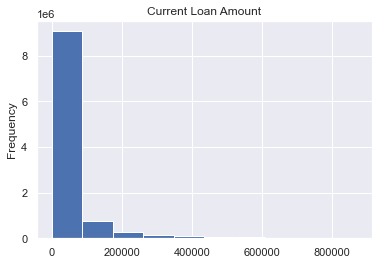

In [18]:
loan_amounts['CurrentApprovalAmount'].plot.hist(title="Current Loan Amount")

<AxesSubplot:title={'center':'Current Loan Amount'}>

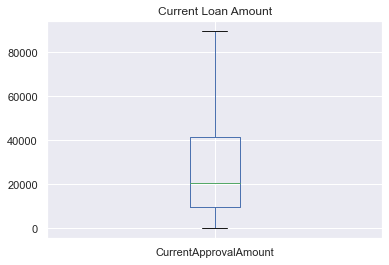

In [19]:
loan_amounts['CurrentApprovalAmount'].plot.box(title="Current Loan Amount", showfliers=False)

<AxesSubplot:title={'center':'Undisbursed Loan Amount'}, ylabel='Frequency'>

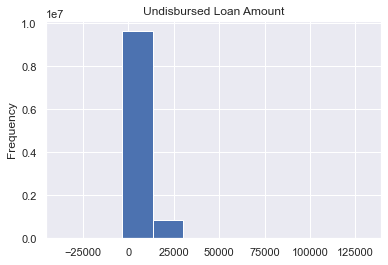

In [20]:
loan_amounts['UndisbursedAmount'].plot.hist(title="Undisbursed Loan Amount")

<AxesSubplot:title={'center':'Undisbursed Loan Amount'}>

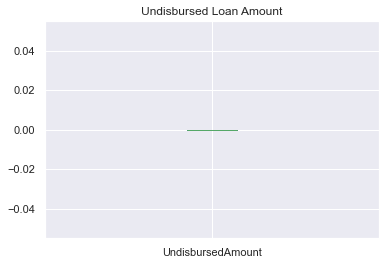

In [21]:
loan_amounts['UndisbursedAmount'].plot.box(title="Undisbursed Loan Amount", showfliers=False)

In [87]:
A = df.groupby(["LoanStatus"])[["InitialApprovalAmount", "CurrentApprovalAmount", "UndisbursedAmount"]].sum()
A

,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount
LoanStatus,,,
ACTIVE UN-DISBURSED,3.730041e+10,3.726029e+10,3.725802e+10
EXEMPTION 4,5.519906e+11,5.497866e+11,8.293796e+07
PAID IN FULL,1.933079e+11,1.915616e+11,1.158000e+05


<AxesSubplot:xlabel='LoanStatus'>

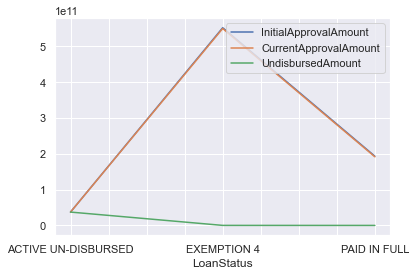

In [88]:
A.plot.line()

In [90]:
B = df.groupby(["BusinessType"])[["InitialApprovalAmount", "CurrentApprovalAmount", "UndisbursedAmount"]].sum()
B

,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount
BusinessType,,,
COOPERATIVE,1.905650e+09,1.899498e+09,2.859063e+07
CORPORATION,2.952041e+11,2.935153e+11,6.520342e+09
EMPLOYEE STOCK OWNERSHIP PLAN(ESOP),9.419028e+08,9.367902e+08,4.253024e+06
HOUSING CO-OP,7.877775e+07,7.878025e+07,1.367579e+07
INDEPENDENT CONTRACTORS,7.841525e+09,7.813195e+09,2.873693e+09
JOINT VENTURE,1.177277e+08,1.176019e+08,8.307821e+06
LIMITED LIABILITY COMPANY(LLC),2.001359e+11,1.991141e+11,6.198398e+09
LIMITED LIABILITY PARTNERSHIP,8.736628e+09,8.747210e+09,2.202953e+08
NON-PROFIT,4.995500e+10,4.967868e+10,2.162442e+09


<AxesSubplot:xlabel='BusinessType'>

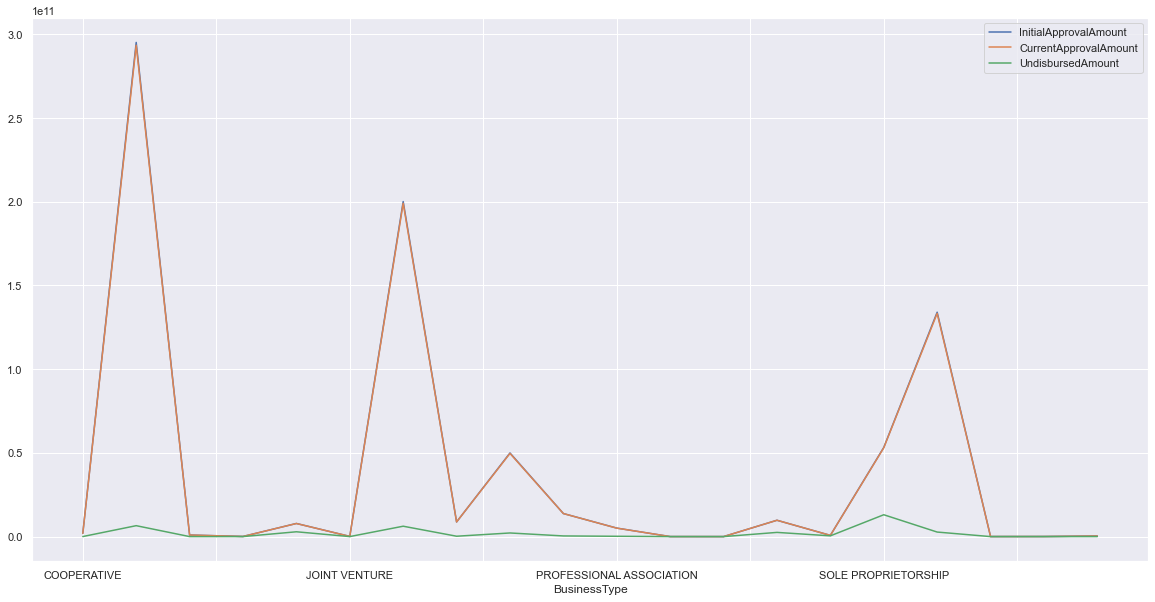

In [91]:
B.plot.line(figsize=(20,10))

<AxesSubplot:>

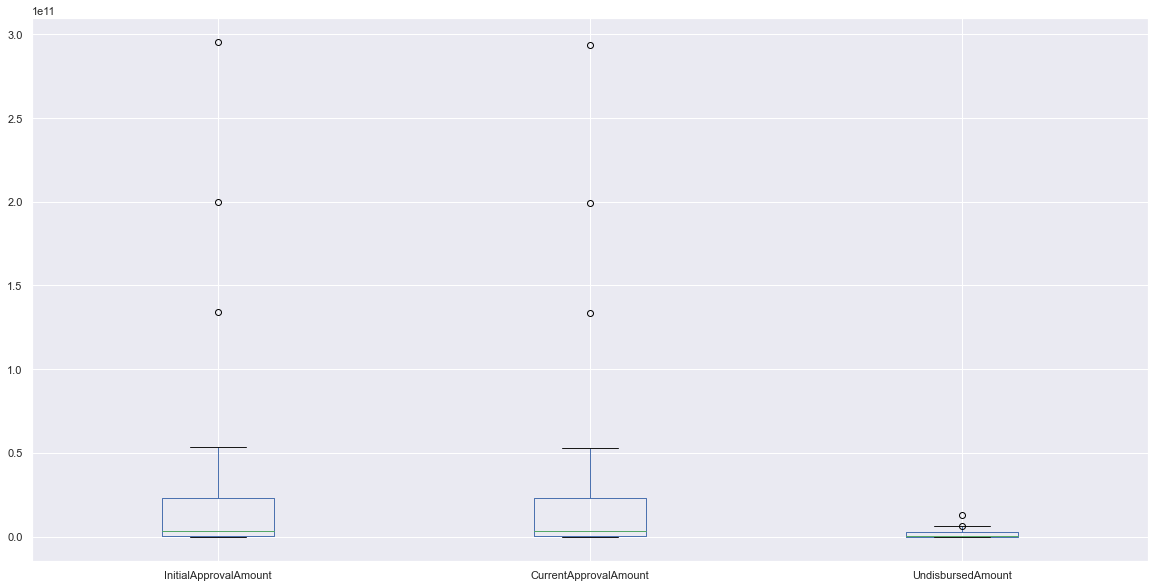

In [93]:
B.plot.box(figsize=(20,10))

### Discussion
The data is all rightly skewed even after removing outliers. The inital and current approval amount seem to have the same boxplot. The box plot for undisbursment amount is very limited in range so it means that most of loan amount is disbursed. I am going to use the current approval amount for two-dimensional distribution. 

## Inspecting one variable against another variables of interest


In [22]:
pd.options.display.max_columns = 100
df.head(5)

,DateApproved,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,LoanStatus,Term,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount,FranchiseName,ServicingLenderName,ServicingLenderCity,ServicingLenderState,ServicingLenderZip,RuralUrbanIndicator,HubzoneIndicator,LMIIndicator,BusinessAgeDescription,ProjectCity,ProjectCountyName,ProjectState,ProjectZip,CD,JobsReported,Race,Ethnicity,UtilitiesProceed,PayrollProceed,MortgageIntProceed,RentProceed,RefinanceEidlProceed,HealthcareProceed,DebtIntProceed,BusinessType,OriginatingLender,OriginatingLenderCity,OriginatingLenderState,Gender,Veteran,NonProfit,Industry
0,2020-05-01,NaN,NaN,NaN,NaN,EXEMPTION 4,24,148440.00,148440.00,0.0,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CHARLOTTE,NC,28202-4024,URBAN,NO,NO,NEW BUSINESS OR 2 YEARS OR LESS,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,148440.00,NaN,NaN,NaN,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CHARLOTTE,NC,NaN,NaN,NaN,DENTAL EQUIPMENT AND SUPPLIES MANUFACTURING
1,2020-05-01,LADSON,NaN,29456-3517,NaN,EXEMPTION 4,24,140081.78,140081.78,0.0,NaN,SYNOVUS BANK,COLUMBUS,GA,31901-2429,URBAN,NO,NO,EXISTING OR MORE THAN 2 YEARS OLD,LADSON,BERKELEY,SC,29456-3517,SC-01,3.0,NaN,NaN,NaN,140081.78,NaN,NaN,NaN,NaN,NaN,LIMITED LIABILITY COMPANY(LLC),SYNOVUS BANK,COLUMBUS,GA,NaN,NaN,NaN,NaN
2,2020-05-01,MANNING,NaN,29102-2734,2021-04-20,PAID IN FULL,24,136520.96,136520.96,0.0,NaN,SYNOVUS BANK,COLUMBUS,GA,31901-2429,URBAN,YES,YES,EXISTING OR MORE THAN 2 YEARS OLD,MANNING,CLARENDON,SC,29102-2734,SC-06,170.0,NaN,NaN,NaN,136520.96,NaN,NaN,NaN,NaN,NaN,LIMITED LIABILITY COMPANY(LLC),SYNOVUS BANK,COLUMBUS,GA,NaN,NaN,NaN,"ALL OTHER PROFESSIONAL, SCIENTIFIC, AND TECHNI..."
3,2020-05-01,REDFORD,NaN,48239-2446,2021-04-16,PAID IN FULL,24,126798.00,126798.00,0.0,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CHARLOTTE,NC,28202-4024,URBAN,YES,NO,NEW BUSINESS OR 2 YEARS OR LESS,REDFORD,WAYNE,MI,48239-2446,MI-13,20.0,NaN,NOT HISPANIC OR LATINO,NaN,126798.00,NaN,NaN,NaN,NaN,NaN,LIMITED LIABILITY COMPANY(LLC),"BANK OF AMERICA, NATIONAL ASSOCIATION",CHARLOTTE,NC,MALE OWNED,NON-VETERAN,NaN,NaN
4,2020-05-01,SPARTANBURG,NaN,29303-2085,NaN,EXEMPTION 4,24,125916.00,125916.00,0.0,NaN,SYNOVUS BANK,COLUMBUS,GA,31901-2429,URBAN,NO,YES,NEW BUSINESS OR 2 YEARS OR LESS,SPARTANBURG,SPARTANBURG,SC,29303-2085,SC-04,13.0,NaN,NaN,NaN,125916.00,NaN,NaN,NaN,NaN,NaN,LIMITED LIABILITY COMPANY(LLC),SYNOVUS BANK,COLUMBUS,GA,NaN,NaN,NaN,UNCLASSIFIED ESTABLISHMENTS


Text(0.5, 1.0, 'Boxplot of Current Approval Amount vs. Rural Urban Indicator')

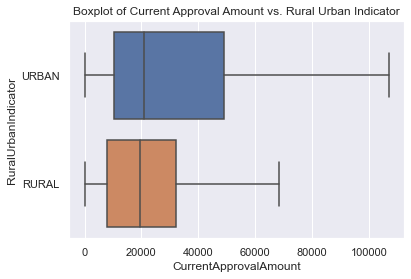

In [23]:
sns.boxplot(x = "CurrentApprovalAmount", y='RuralUrbanIndicator', data = df, showfliers = False)
plt.title("Boxplot of Current Approval Amount vs. Rural Urban Indicator")

Text(0.5, 1.0, 'Boxplot of Current Approval Amount vs. LMI Indicator')

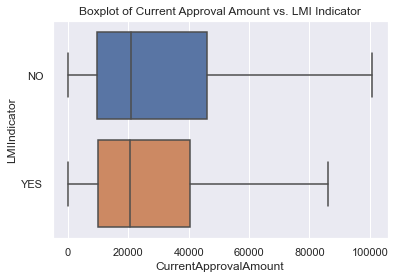

In [24]:
sns.boxplot(x = "CurrentApprovalAmount", y='LMIIndicator', data = df, showfliers = False)
plt.title("Boxplot of Current Approval Amount vs. LMI Indicator")

Text(0.5, 1.0, 'Boxplot of Current Approval Amount vs. Hubzone Indicator')

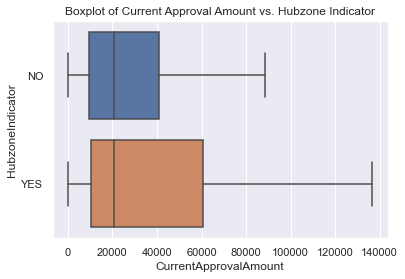

In [25]:

sns.boxplot(x = "CurrentApprovalAmount", y='HubzoneIndicator', data = df, showfliers = False)
plt.title("Boxplot of Current Approval Amount vs. Hubzone Indicator")

Text(0.5, 1.0, 'Boxplot of Current Approval Amount vs. Race')

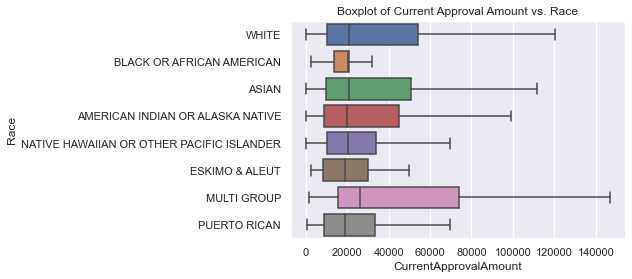

In [26]:
sns.boxplot(x = "CurrentApprovalAmount", y='Race', data = df, showfliers = False)
plt.title("Boxplot of Current Approval Amount vs. Race")

Text(0.5, 1.0, 'Boxplot of Undisbursed Amount vs. Race')

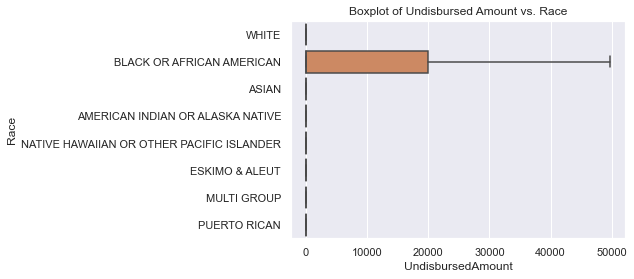

In [27]:
sns.boxplot(x = "UndisbursedAmount", y='Race', data = df, showfliers = False)
plt.title("Boxplot of Undisbursed Amount vs. Race")

Text(0.5, 1.0, 'Boxplot of Current Approval Amount vs. Ethnicity')

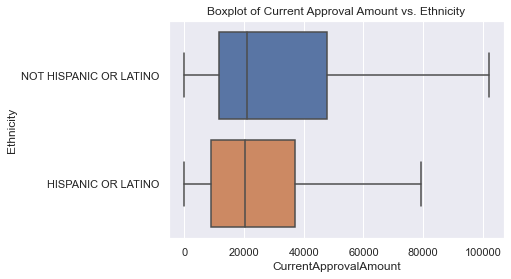

In [28]:
sns.boxplot(x = "CurrentApprovalAmount", y='Ethnicity', data = df, showfliers = False)
plt.title("Boxplot of Current Approval Amount vs. Ethnicity")

Text(0.5, 1.0, 'Boxplot of Current Approval Amount vs. Business Type')

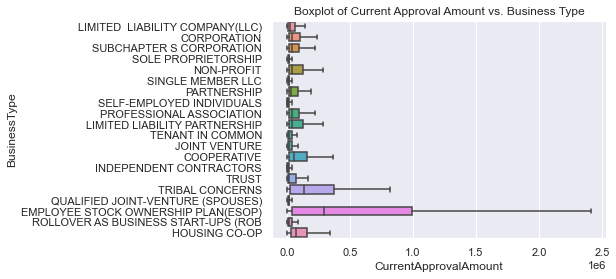

In [29]:
sns.boxplot(x = "CurrentApprovalAmount", y='BusinessType', data = df, showfliers = False)
plt.title("Boxplot of Current Approval Amount vs. Business Type")

Text(0.5, 1.0, 'Boxplot of Undisbursed Amount vs. Business Type')

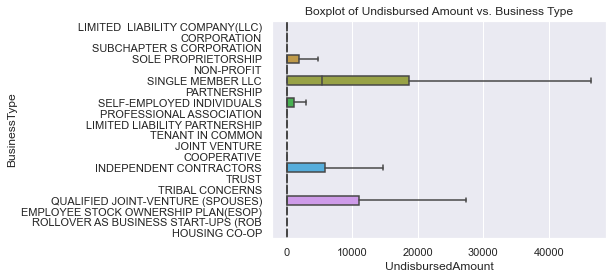

In [30]:
sns.boxplot(x = "UndisbursedAmount", y='BusinessType', data = df, showfliers = False)
plt.title("Boxplot of Undisbursed Amount vs. Business Type")

Text(0.5, 1.0, 'Boxplot of Current Approval Amount vs. Gender')

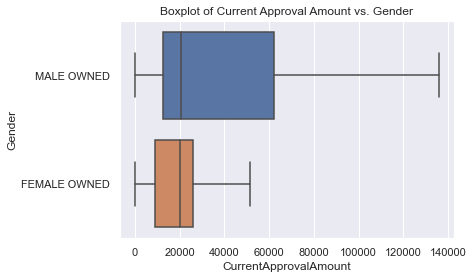

In [31]:
sns.boxplot(x = "CurrentApprovalAmount", y='Gender', data = df, showfliers = False)
plt.title("Boxplot of Current Approval Amount vs. Gender")

Text(0.5, 1.0, 'Boxplot of Current Approval Amount vs. Veteran')

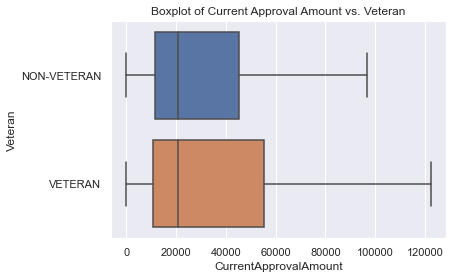

In [32]:
sns.boxplot(x = "CurrentApprovalAmount", y='Veteran', data = df, showfliers = False)
plt.title("Boxplot of Current Approval Amount vs. Veteran")

### Discusion
Due to the lack of numerical values, I plotted current approved amount against non-numerical demographic: 

*this data dosen't include outliers

- Urban has a large size and share of current approval amount compared to rural.
- There is also a bigger share for business that are not low-median income which is suprising because you except them to be the most excepted.
- There is a larger share of busniess in historical underutilized business zone (Hubzone) compared to those who aren’t. The difference of the max between the two is around 30,000.
- For race, it is suprising that multi-group have such a wide range of people approved for loans. More research needs to be done in what multi-group is.However, it is not suprising that white people have a greater share compared to other racial groups.  Followed by white people are Asian people and Native American. On the other side, Black or African American have the smallest share of approved loans.
    - Interestingly, when you look at undisbursed amount against race, black american is the only one with a min at 0 and a max at 50,000. 
- For ethnicity, it is not suprising that not hispanic or latino people have a bigger share of loans compared to hispanic/latino.
- For businses type, I am very confused on how employee stock ownership plan have such a abnormal amount of loans.
    - Looking at undisbursed amount, single member llc, qualified joint-venture and independent contracters have the biggest share.
- Male-owned businesses have an almost 5 times bigger size than female-owned businesses. 
- For veteran, it shows that veterans have a bigger size but I believe that the outlier must be skewing this greatly.


## Investigating correlations

In [33]:
pd.options.display.max_columns = 100
df.head(5)

,DateApproved,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,LoanStatus,Term,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount,FranchiseName,ServicingLenderName,ServicingLenderCity,ServicingLenderState,ServicingLenderZip,RuralUrbanIndicator,HubzoneIndicator,LMIIndicator,BusinessAgeDescription,ProjectCity,ProjectCountyName,ProjectState,ProjectZip,CD,JobsReported,Race,Ethnicity,UtilitiesProceed,PayrollProceed,MortgageIntProceed,RentProceed,RefinanceEidlProceed,HealthcareProceed,DebtIntProceed,BusinessType,OriginatingLender,OriginatingLenderCity,OriginatingLenderState,Gender,Veteran,NonProfit,Industry
0,2020-05-01,NaN,NaN,NaN,NaN,EXEMPTION 4,24,148440.00,148440.00,0.0,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CHARLOTTE,NC,28202-4024,URBAN,NO,NO,NEW BUSINESS OR 2 YEARS OR LESS,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,148440.00,NaN,NaN,NaN,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CHARLOTTE,NC,NaN,NaN,NaN,DENTAL EQUIPMENT AND SUPPLIES MANUFACTURING
1,2020-05-01,LADSON,NaN,29456-3517,NaN,EXEMPTION 4,24,140081.78,140081.78,0.0,NaN,SYNOVUS BANK,COLUMBUS,GA,31901-2429,URBAN,NO,NO,EXISTING OR MORE THAN 2 YEARS OLD,LADSON,BERKELEY,SC,29456-3517,SC-01,3.0,NaN,NaN,NaN,140081.78,NaN,NaN,NaN,NaN,NaN,LIMITED LIABILITY COMPANY(LLC),SYNOVUS BANK,COLUMBUS,GA,NaN,NaN,NaN,NaN
2,2020-05-01,MANNING,NaN,29102-2734,2021-04-20,PAID IN FULL,24,136520.96,136520.96,0.0,NaN,SYNOVUS BANK,COLUMBUS,GA,31901-2429,URBAN,YES,YES,EXISTING OR MORE THAN 2 YEARS OLD,MANNING,CLARENDON,SC,29102-2734,SC-06,170.0,NaN,NaN,NaN,136520.96,NaN,NaN,NaN,NaN,NaN,LIMITED LIABILITY COMPANY(LLC),SYNOVUS BANK,COLUMBUS,GA,NaN,NaN,NaN,"ALL OTHER PROFESSIONAL, SCIENTIFIC, AND TECHNI..."
3,2020-05-01,REDFORD,NaN,48239-2446,2021-04-16,PAID IN FULL,24,126798.00,126798.00,0.0,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CHARLOTTE,NC,28202-4024,URBAN,YES,NO,NEW BUSINESS OR 2 YEARS OR LESS,REDFORD,WAYNE,MI,48239-2446,MI-13,20.0,NaN,NOT HISPANIC OR LATINO,NaN,126798.00,NaN,NaN,NaN,NaN,NaN,LIMITED LIABILITY COMPANY(LLC),"BANK OF AMERICA, NATIONAL ASSOCIATION",CHARLOTTE,NC,MALE OWNED,NON-VETERAN,NaN,NaN
4,2020-05-01,SPARTANBURG,NaN,29303-2085,NaN,EXEMPTION 4,24,125916.00,125916.00,0.0,NaN,SYNOVUS BANK,COLUMBUS,GA,31901-2429,URBAN,NO,YES,NEW BUSINESS OR 2 YEARS OR LESS,SPARTANBURG,SPARTANBURG,SC,29303-2085,SC-04,13.0,NaN,NaN,NaN,125916.00,NaN,NaN,NaN,NaN,NaN,LIMITED LIABILITY COMPANY(LLC),SYNOVUS BANK,COLUMBUS,GA,NaN,NaN,NaN,UNCLASSIFIED ESTABLISHMENTS


In [34]:
corr_df = df[['BorrowerState',
             'ServicingLenderName',
              'RuralUrbanIndicator',
              'HubzoneIndicator',
              'LMIIndicator',
              'BusinessAgeDescription',
              'JobsReported',
              'Race',
              'Ethnicity',
              'BusinessType',
              'OriginatingLender',
              'Gender',
              'Veteran',
              'NonProfit',
              'Industry'
             ]]

In [35]:
#Factorizing the str columns to floats
corr_df = corr_df.apply(lambda x: x.factorize()[0])

In [36]:
corr_df

,BorrowerState,ServicingLenderName,RuralUrbanIndicator,HubzoneIndicator,LMIIndicator,BusinessAgeDescription,JobsReported,Race,Ethnicity,BusinessType,OriginatingLender,Gender,Veteran,NonProfit,Industry
0,-1,0,0,0,0,0,0,-1,-1,-1,0,-1,-1,-1,0
1,-1,1,0,0,0,1,1,-1,-1,0,1,-1,-1,-1,-1
2,-1,1,0,1,1,1,2,-1,-1,0,1,-1,-1,-1,1
3,-1,0,0,1,0,0,3,-1,0,0,0,0,0,-1,-1
4,-1,1,0,0,1,0,4,-1,-1,0,1,-1,-1,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697214,57,1393,0,0,0,1,21,-1,0,1,1399,0,0,-1,5
10697215,57,1459,0,0,0,1,50,-1,-1,4,1465,-1,-1,0,162
10697216,57,2343,0,1,0,1,14,-1,-1,2,2354,1,-1,-1,71
10697217,57,594,1,0,0,0,8,-1,-1,1,597,-1,-1,-1,8


In [37]:
#Adding back the numerical columns
corr_df['InitialApprovalAmount'] = df[['InitialApprovalAmount']]
corr_df['CurrentApprovalAmount'] = df[['CurrentApprovalAmount']]
corr_df['UndisbursedAmount'] = df[['UndisbursedAmount']]
corr_df['UtilitiesProceed'] = df[['UtilitiesProceed']]
corr_df['PayrollProceed'] = df[['PayrollProceed']]
corr_df['MortgageIntProceed'] = df[['MortgageIntProceed']]
corr_df['RentProceed'] = df[['RentProceed']]
corr_df['RefinanceEidlProceed'] = df[['RefinanceEidlProceed']]
corr_df['HealthcareProceed'] = df[['HealthcareProceed']]
corr_df['DebtIntProceed'] = df[['DebtIntProceed']]

In [38]:
corrm = corr_df.corr()

In [39]:
corrm

,BorrowerState,ServicingLenderName,RuralUrbanIndicator,HubzoneIndicator,LMIIndicator,BusinessAgeDescription,JobsReported,Race,Ethnicity,BusinessType,OriginatingLender,Gender,Veteran,NonProfit,Industry,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount,UtilitiesProceed,PayrollProceed,MortgageIntProceed,RentProceed,RefinanceEidlProceed,HealthcareProceed,DebtIntProceed
BorrowerState,1.000000,0.135531,0.104290,0.020981,-0.030889,0.000595,0.006925,-0.039292,-0.004524,-0.034797,0.136923,-0.008747,-0.012519,0.017039,0.007201,0.009899,0.010161,-0.001848,0.003979,0.010151,-0.005084,0.003618,-0.020903,0.010048,-0.003086
ServicingLenderName,0.135531,1.000000,0.312957,0.034614,-0.089856,0.056640,0.009041,-0.048765,0.052827,-0.088004,0.995514,0.038474,-0.000235,0.048474,0.092962,0.019315,0.019760,-0.011270,0.013828,0.019381,0.012326,0.008027,-0.002876,0.041339,0.038508
RuralUrbanIndicator,0.104290,0.312957,1.000000,0.086839,-0.100112,0.050382,-0.021771,-0.038091,0.012400,-0.002977,0.310735,0.002513,-0.018523,0.015462,0.160916,-0.039144,-0.039046,-0.011972,-0.006816,-0.039265,-0.013283,-0.035885,0.001097,0.005445,0.017983
HubzoneIndicator,0.020981,0.034614,0.086839,1.000000,0.375008,-0.030862,0.016258,-0.005926,0.007048,-0.054815,0.034137,-0.007751,-0.012350,0.041974,-0.000836,0.029280,0.029521,-0.019403,0.011416,0.029546,0.007631,-0.002552,0.003567,0.022765,0.012878
LMIIndicator,-0.030889,-0.089856,-0.100112,0.375008,1.000000,0.012833,0.005165,0.061927,0.031352,0.066433,-0.090345,0.038055,0.035986,0.009332,-0.014650,-0.002374,-0.002396,0.014367,-0.004530,-0.002224,0.012532,0.002511,0.009927,0.026133,0.011967
BusinessAgeDescription,0.000595,0.056640,0.050382,-0.030862,0.012833,1.000000,0.005344,0.053213,0.062931,0.064475,0.054999,0.085164,0.077987,-0.008667,0.058489,-0.004601,-0.004371,0.026845,-0.034551,-0.005185,0.009849,0.016658,-0.047290,0.036998,0.018664
JobsReported,0.006925,0.009041,-0.021771,0.016258,0.005165,0.005344,1.000000,-0.022567,-0.010357,-0.027382,0.008942,-0.013954,-0.008914,0.070749,0.012908,0.689867,0.693976,0.080337,0.246054,0.691694,0.354896,0.476176,0.041628,0.496306,0.283501
Race,-0.039292,-0.048765,-0.038091,-0.005926,0.061927,0.053213,-0.022567,1.000000,0.572947,0.028181,-0.049263,0.548434,0.541428,-0.044907,-0.012480,-0.036004,-0.036156,0.012516,-0.027640,-0.035904,0.000040,-0.014863,0.020117,-0.007301,0.004295
Ethnicity,-0.004524,0.052827,0.012400,0.007048,0.031352,0.062931,-0.010357,0.572947,1.000000,-0.011049,0.052246,0.676696,0.673544,-0.051587,-0.006423,-0.017313,-0.017388,0.009285,-0.021506,-0.017255,-0.005347,-0.011114,0.001085,-0.012941,-0.001333
BusinessType,-0.034797,-0.088004,-0.002977,-0.054815,0.066433,0.064475,-0.027382,0.028181,-0.011049,1.000000,-0.089444,0.012639,0.001725,0.054385,0.063646,-0.094812,-0.095163,0.011111,-0.028886,-0.095216,-0.029654,-0.013813,-0.009829,0.032546,-0.002487


In [40]:
pos_cor = corrm['CurrentApprovalAmount'] >0
corrm['CurrentApprovalAmount'][pos_cor].sort_values(ascending = False).to_frame()

,CurrentApprovalAmount
CurrentApprovalAmount,1.000000
PayrollProceed,0.996073
InitialApprovalAmount,0.989613
HealthcareProceed,0.720716
RentProceed,0.704551
JobsReported,0.693976
MortgageIntProceed,0.474522
DebtIntProceed,0.380312
UtilitiesProceed,0.377702
UndisbursedAmount,0.138294


In [41]:
neg_cor = corrm['CurrentApprovalAmount'] <0
corrm['CurrentApprovalAmount'][neg_cor].sort_values(ascending = True).to_frame()

,CurrentApprovalAmount
BusinessType,-0.095163
RuralUrbanIndicator,-0.039046
Race,-0.036156
Gender,-0.025157
Ethnicity,-0.017388
Veteran,-0.014432
BusinessAgeDescription,-0.004371
LMIIndicator,-0.002396


In [42]:
pos_cor_2 = corrm['UndisbursedAmount'] >0
corrm['UndisbursedAmount'][pos_cor_2].sort_values(ascending = False).to_frame()

,UndisbursedAmount
UndisbursedAmount,1.000000
PayrollProceed,0.143473
CurrentApprovalAmount,0.138294
InitialApprovalAmount,0.135454
JobsReported,0.080337
BusinessAgeDescription,0.026845
RentProceed,0.020407
NonProfit,0.017666
LMIIndicator,0.014367
Veteran,0.013484


In [43]:
neg_cor_2 = corrm['UndisbursedAmount'] <0
corrm['UndisbursedAmount'][neg_cor_2].sort_values(ascending = True).to_frame()

,UndisbursedAmount
HubzoneIndicator,-0.019403
RuralUrbanIndicator,-0.011972
OriginatingLender,-0.011622
ServicingLenderName,-0.011270
UtilitiesProceed,-0.006440
BorrowerState,-0.001848


### Discussion

- I am not suprised about the correlations with the various loan proceed. But there is chance for more exploration with the variation of correlations for proceed. 
- It is interesting that the borrow state, industry, originatinglender, servicinglender, and nonprofit are postively correlated for approval amount. 
- Looking at undisbursed amount, demographic data becomes a strong correlation which earns furthur exploration.
- The difference in the negative correlation for current loan amount and undisbursed also warrants furthur research especially looking at demographics. 

## Investigating for Independence Between Two Variables

### Things to Keep in Mind

#### Below 0.05, significant. Over 0.05, not significant. 
If p value > .10 → “not significant”

If p value ≤ .10 → “marginally significant”

If p value ≤ .05 → “significant”

If p value ≤ .01 → “highly significant.”


**True** : If the output p-value is less than the significance level that means that we can **reject the null hypothesis** and the two variables are **not independent**.

**False** : If The output p-value is greater than the significance level (p=0.05 in most cases) that means that **there is not enough evidence to reject the null hypothesis**. In other words, the means of samples **A and B are statistically indistinguishable**.

In [44]:
#Running a ttest with two datasets
pingouin.ttest(df["CurrentApprovalAmount"],  df["RentProceed"])

/Users/adwoanyame/opt/anaconda3/lib/python3.8/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,525.569203,2.396821e+06,two-sided,0.0,"[57369.19, 57798.68]",0.221595,inf,1.0


In [45]:
#Storing numerical values into new values
current_approval = df[['CurrentApprovalAmount']]
undisbursed = df[['UndisbursedAmount']]
payroll = df[['PayrollProceed']]
health = df[['HealthcareProceed']]
rent = df[['RentProceed']]
job = df[['JobsReported']]
mortgage = df[['MortgageIntProceed']]
debt = df[['DebtIntProceed']]
utilites = df[['UtilitiesProceed']]
refinance = df[['RefinanceEidlProceed']]

In [46]:
#Get the p-value using ttest
import scipy.stats as stats
stat = stats.ttest_ind(a=current_approval, b=health, equal_var=True, nan_policy='omit')
p = stat[1].item()
p

0.0

In [47]:
#Test for significance 
sig = p <= 0.05 
sig

True

## Discusion:

Proccess: Runned ttest with numerical values (proceeds) with Current Approval Amount or Undisbursed Amount.

                            Current Approval Amount
### Reject the Null Hypothesis Variables:
1. Health Proceeds
2. Rent Proceeds
3. Reported Job
4. Mortgage Proceeds
5. Debt Proceeds
6. Utilites Proceeds
7. Refinance Proceeds


### Not Enough Evidence to Reject the Null Hypothesis Variables:
1. Payroll Proceeds



                            Undisbursed Approval Amount
### Reject the Null Hypothesis Variables:
1. Health Proceeds
2. Rent Proceeds
3. Job Proceeds
4. Mortgage Proceeds
5. Utilites Proceeds
6. Payroll Proceeds


### Not Enough Evidence to Reject the Null Hypothesis Variables:
1. Debt Proceeds
2. Refinance Eid Proceeds


In [48]:
df.head(5)

,DateApproved,BorrowerCity,BorrowerState,BorrowerZip,LoanStatusDate,LoanStatus,Term,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount,FranchiseName,ServicingLenderName,ServicingLenderCity,ServicingLenderState,ServicingLenderZip,RuralUrbanIndicator,HubzoneIndicator,LMIIndicator,BusinessAgeDescription,ProjectCity,ProjectCountyName,ProjectState,ProjectZip,CD,JobsReported,Race,Ethnicity,UtilitiesProceed,PayrollProceed,MortgageIntProceed,RentProceed,RefinanceEidlProceed,HealthcareProceed,DebtIntProceed,BusinessType,OriginatingLender,OriginatingLenderCity,OriginatingLenderState,Gender,Veteran,NonProfit,Industry
0,2020-05-01,NaN,NaN,NaN,NaN,EXEMPTION 4,24,148440.00,148440.00,0.0,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CHARLOTTE,NC,28202-4024,URBAN,NO,NO,NEW BUSINESS OR 2 YEARS OR LESS,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,148440.00,NaN,NaN,NaN,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CHARLOTTE,NC,NaN,NaN,NaN,DENTAL EQUIPMENT AND SUPPLIES MANUFACTURING
1,2020-05-01,LADSON,NaN,29456-3517,NaN,EXEMPTION 4,24,140081.78,140081.78,0.0,NaN,SYNOVUS BANK,COLUMBUS,GA,31901-2429,URBAN,NO,NO,EXISTING OR MORE THAN 2 YEARS OLD,LADSON,BERKELEY,SC,29456-3517,SC-01,3.0,NaN,NaN,NaN,140081.78,NaN,NaN,NaN,NaN,NaN,LIMITED LIABILITY COMPANY(LLC),SYNOVUS BANK,COLUMBUS,GA,NaN,NaN,NaN,NaN
2,2020-05-01,MANNING,NaN,29102-2734,2021-04-20,PAID IN FULL,24,136520.96,136520.96,0.0,NaN,SYNOVUS BANK,COLUMBUS,GA,31901-2429,URBAN,YES,YES,EXISTING OR MORE THAN 2 YEARS OLD,MANNING,CLARENDON,SC,29102-2734,SC-06,170.0,NaN,NaN,NaN,136520.96,NaN,NaN,NaN,NaN,NaN,LIMITED LIABILITY COMPANY(LLC),SYNOVUS BANK,COLUMBUS,GA,NaN,NaN,NaN,"ALL OTHER PROFESSIONAL, SCIENTIFIC, AND TECHNI..."
3,2020-05-01,REDFORD,NaN,48239-2446,2021-04-16,PAID IN FULL,24,126798.00,126798.00,0.0,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CHARLOTTE,NC,28202-4024,URBAN,YES,NO,NEW BUSINESS OR 2 YEARS OR LESS,REDFORD,WAYNE,MI,48239-2446,MI-13,20.0,NaN,NOT HISPANIC OR LATINO,NaN,126798.00,NaN,NaN,NaN,NaN,NaN,LIMITED LIABILITY COMPANY(LLC),"BANK OF AMERICA, NATIONAL ASSOCIATION",CHARLOTTE,NC,MALE OWNED,NON-VETERAN,NaN,NaN
4,2020-05-01,SPARTANBURG,NaN,29303-2085,NaN,EXEMPTION 4,24,125916.00,125916.00,0.0,NaN,SYNOVUS BANK,COLUMBUS,GA,31901-2429,URBAN,NO,YES,NEW BUSINESS OR 2 YEARS OR LESS,SPARTANBURG,SPARTANBURG,SC,29303-2085,SC-04,13.0,NaN,NaN,NaN,125916.00,NaN,NaN,NaN,NaN,NaN,LIMITED LIABILITY COMPANY(LLC),SYNOVUS BANK,COLUMBUS,GA,NaN,NaN,NaN,UNCLASSIFIED ESTABLISHMENTS


In [81]:
my_contingency_table = pd.crosstab(index=df["BusinessType"], columns=df["LoanStatus"])
my_contingency_table

LoanStatus,ACTIVE UN-DISBURSED,EXEMPTION 4,PAID IN FULL
BusinessType,,,
COOPERATIVE,228,5922,3107
CORPORATION,62861,1580900,635412
EMPLOYEE STOCK OWNERSHIP PLAN(ESOP),38,676,394
HOUSING CO-OP,90,481,0
INDEPENDENT CONTRACTORS,234643,395993,39421
JOINT VENTURE,190,1127,293
LIMITED LIABILITY COMPANY(LLC),119312,1597730,614906
LIMITED LIABILITY PARTNERSHIP,2318,39938,16498
NON-PROFIT,10010,158782,94965


In [82]:
proportion_table = pd.crosstab(index=df["BusinessType"], columns=df["LoanStatus"], normalize="columns")*100
proportion_table 

LoanStatus,ACTIVE UN-DISBURSED,EXEMPTION 4,PAID IN FULL
BusinessType,,,
COOPERATIVE,0.015395,0.083707,0.145243
CORPORATION,4.244614,22.345776,29.703615
EMPLOYEE STOCK OWNERSHIP PLAN(ESOP),0.002566,0.009555,0.018418
HOUSING CO-OP,0.006077,0.006799,0.000000
INDEPENDENT CONTRACTORS,15.843990,5.597300,1.842814
JOINT VENTURE,0.012830,0.015930,0.013697
LIMITED LIABILITY COMPANY(LLC),8.056401,22.583666,28.745020
LIMITED LIABILITY PARTNERSHIP,0.156520,0.564517,0.771232
NON-PROFIT,0.675913,2.244359,4.439330


Text(0.5, 1.0, 'Title')

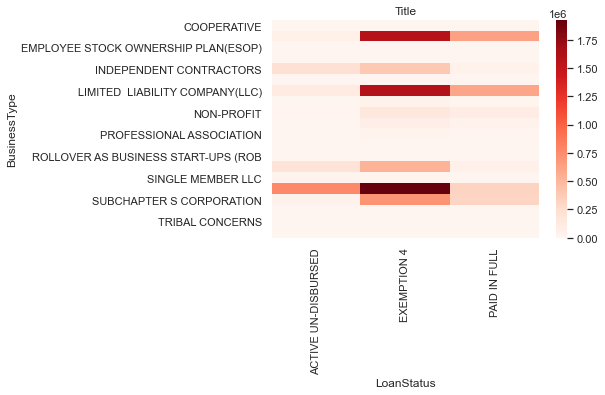

In [83]:
#Visualize your contigency table via heatmap
ax = sns.heatmap(my_contingency_table, cmap="Reds")
ax.set_title("Title")

Text(0.5, 1.0, 'Title')

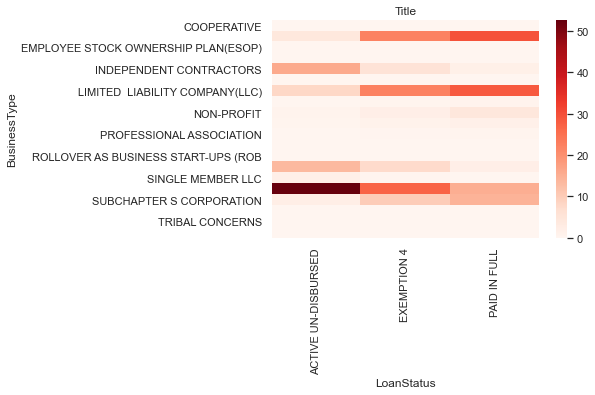

In [84]:
#Visualize proportion contigency table via heatmap
ax = sns.heatmap(proportion_table, cmap="Reds")
ax.set_title("Title")

In [86]:
#P-Value of contigency table

from scipy.stats import chi2_contingency

chi2_contingency(my_contingency_table)[1]

0.0

## Discussion

Process: Running a chi test on a contigency table 

### Reject the Null Hypothesis Variables:
1. LMIIndicator and HubzoneIndicator
2. Race and LMIIndicator - explore more
3. Race and HubzoneIndicator - explore more
4. Race and BorrowerState - explore more
5. LMIIndicator and BorrowerState - explore more
6. Gender and BorrowerState - explore more
7. Gender and Race - explore more
8. Gender and LMIIndicator
9. Gender and Industry
10. Race and Industry
11. Race and BusinessAgeDescription
12. Race and CD
13. Loan Status and BusinessType

### Not Enough Evidence to Reject the Null Hypothesis Variables:
1. Race and Nonprofit
2. Gender and BusinessAgeDescription
